In [1]:
#### Keras implementation of NN's which we will look at MNIST with

from __future__ import print_function
#import keras as keras 
#from keras import backend as K
#from keras.datasets import mnist
#from keras.models import Sequential
#from keras.layers import Dense, Dropout, Flatten
#from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
#from keras.constraints import max_norm
#from keras.regularizers import L2
import tensorflow as tf
#import tensorflow_datasets as tfds
#import scipy
#import h5py
import os
from matplotlib import pyplot as plt
import numpy as np
import time
#svhn_path="../Datasets/svhn"#"/Home/Adam/Research/Datasets/svhn"
# Hyper-parameters
#K.clear_session() ## needed???
batch_size = 128
num_classes = 10
epochs = 10

img_rows, img_cols = 32, 32
## where did you put mnist_transfer
path_to_root_file="/home/adam/Code/"
### making sure that we have the GPU to work on
gpus = tf.config.experimental.list_physical_devices('GPU')
#logical_gpus = tf.config.experimental.list_logical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 4GB of memory on the first GPU
  # I do not know why I have to do this but gpu does not work otherwise.
    try:
        tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


mean, variance 0.36348352 70.18035
---------------Load MNIST----------------
Training set (60000, 32, 32, 3) (60000, 10)
Test set (10000, 32, 32, 3) (10000, 10)


mean, variance 1.1809415 74.36859
---------------Load MNIST-M----------------
Training set (60000, 32, 32, 3) (60000, 10)
Test set (10000, 32, 32, 3) (10000, 10)


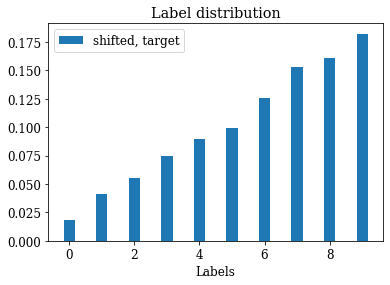

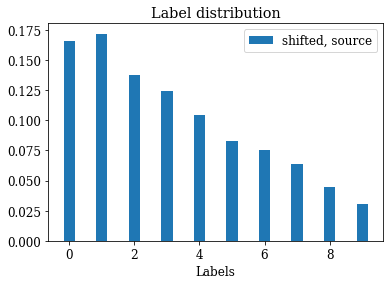

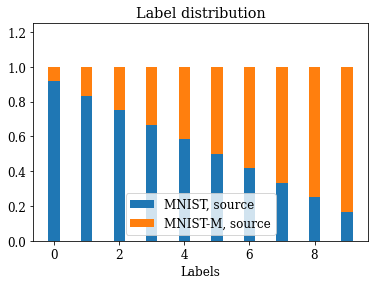

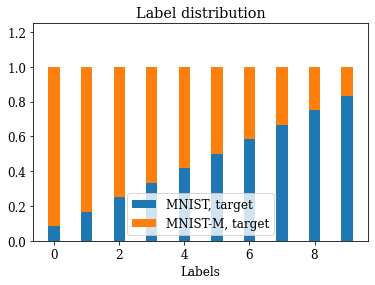

In [2]:

### load module, and also MNIST/MNIST-M
from importlib.machinery import SourceFileLoader
mymodule = SourceFileLoader('mnistm', path_to_root_file+'mnist_transfer/data/mnist_m.py').load_module()
mymodule2 = SourceFileLoader('mnist', path_to_root_file+'mnist_transfer/data/mnist.py').load_module()
import mnistm
import mnist
x_train, y_train, x_test, y_test = mnist.load_mnist()
x_train_m, y_train_m, x_test_m, y_test_m = mnistm.load_mnistm(y_train,y_test)


### load module
from importlib.machinery import SourceFileLoader
mymodule = SourceFileLoader('label_shift', path_to_root_file+'mnist_transfer/data/label_shift.py').load_module()

from label_shift import *
    
######### Here we use the functions from label_shift ##############################################################

###### Add train and test together and shift the distributions to create source and target distributions
### MNIST all data
x_full=np.append(x_train,x_test, axis=0)
y_full=np.append(y_train,y_test, axis=0)
### MNIST-M all data
x_full_m=np.append(x_train_m,x_test_m, axis=0)
y_full_m=np.append(y_train_m,y_test_m, axis=0)
#x_shift,y_shift,x_shift_target,y_shift_target =label_shift(x_train,y_train,1/2,7)
x_shift, y_shift, x_shift_target, y_shift_target =label_shift_linear(x_full,y_full,1/12,[0,1,2,3,4,5,6,7,8,9])
x_shift_m, y_shift_m,x_shift_target_m, y_shift_target_m=label_shift_linear(x_full_m,y_full_m,1/12,[0,1,2,3,4,5,6,7,8,9],decreasing=False)
#rint("test of shift")
#print(x_shift_target.shape)
#print(x_shift.shape)
#print(y_shift_target.shape)
#print(y_shift.shape)
plot_labeldist([0,1,2,3,4,5,6,7,8,9],y_shift_target,"shifted, target")
plot_labeldist([0,1,2,3,4,5,6,7,8,9],y_shift,"shifted, source")
plot_splitbars([0,1,2,3,4,5,6,7,8,9],y_shift,y_shift_m,"MNIST, source","MNIST-M, source")
plot_splitbars([0,1,2,3,4,5,6,7,8,9],y_shift_target,y_shift_target_m,"MNIST, target","MNIST-M, target")






In [3]:
##### Add the label shifted datasets to each other creating the source and target domain for task 2

##### calculate the label densities here
densities=[]
densities.append(np.sum(y_shift,axis=0))
densities.append(np.sum(y_shift_m,axis=0))
densities.append(np.sum(y_shift_target,axis=0))
densities.append(np.sum(y_shift_target_m,axis=0))
# mnist source, mnist-m source, mnist target,  mnist-m target
#print(densities)
TASK=2
if TASK==1:
    x_source=x_shift
    y_source=y_shift
    x_target=x_shift_target
    y_target=y_shift_target
elif TASK==2:
    L=len(densities[0])
    interdomain_densities = [[] for x in range(2)]
    for i in range(L):
        ## all densities are # in mnist over # in mnist-m
        interdomain_densities[0].append(densities[0][i]/densities[1][i])
        interdomain_densities[1].append(densities[2][i]/densities[3][i])
    print(interdomain_densities)
    x_source=np.append(x_shift,x_shift_m, axis=0)
    y_source=np.append(y_shift,y_shift_m, axis=0)
    x_target=np.append(x_shift_target,x_shift_target_m, axis=0)
    y_target=np.append(y_shift_target,y_shift_target_m, axis=0)
    





[[10.986111, 5.0, 2.999428, 1.99958, 1.399789, 1.0, 0.71435696, 0.5, 0.33346358, 0.20003448], [0.09088036, 0.19987813, 0.33326975, 0.5, 0.7143216, 1.0, 1.4001397, 2.0, 3.0, 5.0025883]]


In [ ]:
##### load the splits from the file and make the split on the data

##  This is if we need to divide this up into a train and test set
import sys
import pickle
pkl_file=open('splits_task1.pkl','rb')
split1=pickle.load(pkl_file)
pkl_file.close()
traindata=[]
train_y=[]
testdata=[]
test_y=[]
print(np.max(split1[0]))
for i in split1[0]:
    train_y.append(y_shift[i])
    traindata.append(x_shift[i])
for i in split1[1]:
    test_y.append(y_shift[i])
    testdata.append(x_shift[i])
print(np.sum(train_y,axis=1))
print(np.sum(test_y,axis=1))


In [ ]:
### load SVHN
#from importlib.machinery import SourceFileLoader
#mymodule = SourceFileLoader('svhn', path_to_root_file+'mnist_transfer/data/svhn.py').load_module()
#import svhn 
#X_train, Y_train, X_test, Y_test=svhn.load_svhn()

In [ ]:
### load module
#mymodule = SourceFileLoader('misc', path_to_root_file+'mnist_transfer/util/misc.py').load_module()

#from misc import *
def make_mnist_binary(y):#### test that this works and can be trained!
    '''
    takes in mnist labels and returns a binarisation
    i.e. 0-4 is 0 and 5-9 is 1 for example
    '''
    
    new_y=[None]*len(y)
    for label in range(len(y)):
        if y[label][0] or y[label][1] or y[label][2] or y[label][3] or y[label][4]:
            new_y[label]=0
        else:
            new_y[label]=1
    return tf.keras.utils.to_categorical(new_y, num_classes=2)
#y_train_new=make_mnist_binary(y_train)
#y_test_new=make_mnist_binary(y_test)

In [ ]:
########## testing images and such



#print(X_test)
#print("----------------------------------------------------")
#print(x_test)

#print(make_mnist_binary(y_train))
#plt.imshow(x_test_m[605]) 
#print(x_test_m[303])
#print(y_test_m[605])
#plt.imshow(x_test[605]) 
#print(x_test[303])
#print(y_test[605])

In [ ]:

def flatten_images(x_train,x_train_m):
    ### flatten images into vectors to be able to compute MMD
    mnist_flat=[None]*len(x_train)
    mnistm_flat=[None]*len(x_train)
    for i in range(len(x_train)):
        mnist_flat[i]=tf.reshape(x_train[i],[-1])
        mnistm_flat[i]=tf.reshape(x_train_m[i],[-1])
    #print(np.array(mnist_flat).shape)
    #print(np.array(mnistm_flat).shape)
    return mnist_flat, mnistm_flat
mnist_flat, mnistm_flat=flatten_images(x_train,x_train_m)

In [ ]:

import math
def mmd_linear(x,y,sigma_square):
    """
    Here we want to compute the unbiased estimate of the MMD in linear time using the formula
    MMD^2_k(p,q)=2/n_s for i=1 to n_s/2 g_k(z_i)
    ,where z_i=(x^s_2i-1,x^s_2i,x^t_2i-1,x^t_2i) and
    g_k(z_i)= k(x^s_2i-1,x^s_2i)+k(x^t_2i-1,x^t_2i)-k(x^s_2i-1,x^t_2i)-k(x^s_2i,x^t_2i-1)
    """
    
    
    ##take out odd and even entries for the two vectors
    x_even=x[::2]
    x_odd=x[1:][::2]
    y_even=y[::2]
    y_odd=y[1:][::2]
  #  print(x_odd)
  #  print(x_even)
    n_s=len(x)
    
    mmd=0
    for i in range(round(n_s/2.0)):
        ### sum the kernels for the chosen pairs
        mmd+=kernel(x_even[i],x_odd[i],sigma_square)
        mmd+=kernel(y_even[i],y_odd[i],sigma_square)
        mmd-=kernel(x_even[i],y_odd[i],sigma_square)
        mmd-=kernel(y_even[i],x_odd[i],sigma_square)
    mmd=mmd*(2/n_s)
    return mmd
def kernel(x,y,sigma_square):
    return np.exp(-np.sum(np.square(x-y))/(2*sigma_square))#*1/(np.sqrt(2*math.pi*sigma_square))
#print(kernel(np.array(mnist_flat[0]),np.array(mnistm_flat[0])))
#mmd_linear(mnist_flat,mnistm_flat)
##### do this for a range of sigma and sum the results for an estimation of the true MMD

sigmas = [
      1e-6, 1e-5, 
      1e-4, 1e-3, 1e-2, 1e-1, 1, 5, 10, 15, 20, 25, 30, 35, 100,
      1e3, 1e4, 1e5, 1e6
  ]

mmdlist=[]


#### generate data from two gaussian distributions with different mean and compute mmd?
#x=[1,2,3,4]
#y=[4,4,4,4]
#print(mmd_linear(x,y,1e5))
#for sigma in sigmas:
    #mmdlist.append(mmd_linear(mnist_flat,mnistm_flat,sigma))
#print(mmdlist)
#finalmmd=np.sqrt(np.sum(mmdlist))
#print(finalmmd)
#### test with normal dist

MMDsq=[]
for i in range(4000):
    samples = np.random.normal(0, 1, 100);
    samples2= np.random.normal(0, 3*np.sqrt(2), 100);
    #samples2= np.random.normal(0, 1, 100);
    #mmds=[]
    #for sigma in sigmas:
        #mmds.append(mmd_linear(samples,samples2,sigma))
    MMDsq.append(mmd_linear(samples,samples2,0.5))
    #MMDsq.append(np.sum(mmds))
print("-------------------------------------------------------------")
#print(MMDsq)
print(np.mean(MMDsq))
#plt.xlim([0.05,0.4])
plt.hist(MMDsq,bins=30);
### mnist vs mnistm: 0.5367568640253743

### label shift:


#mymodule = SourceFileLoader('kl', path_to_root_file+'mnist_transfer/util/kl.py').load_module()
#import kl
#print(kl.estimate_KL(samples,samples2,1))
#### KL with N(0,1) vs N(5,1): ~13000 expected 12500 on average so seems about right


In [ ]:
### load module
mymodule = SourceFileLoader('train', path_to_root_file+'mnist_transfer/experiments/training.py').load_module()
mymodule2 = SourceFileLoader('plotting', path_to_root_file+'mnist_transfer/results/plotting.py').load_module()
from plotting import * 
from train import *



"""
#test for MNIST-> MNIST-M
total_epochs=20 #

iterations=1
histories=[]

#histories=train_model(model="2MNIST-M",total_epochs=total_epochs,x_train=x_train,y_train=y_train_new,x_test=x_test,y_test=y_test_new)#,x_target=x_test_m,y_target=y_test_m)
                      
##### Aggregating over all the training runs                    
K=histories[0].keys()
                
result={}
for key in K:
    tmp=[]
    for epoch in range(len(histories)):
        tmp.append(histories[epoch][key])
    result[key]=tmp

for key in K:
    result[key]=np.mean(result[key],axis=0)

    
## plotting and saving to disk
plot_results(model="2MNIST-M",result=result,xlabel="Epoch",total_epochs=total_epochs,save=False)

"""

In [4]:
## custom callback to terminate training at some specific value of a metric
class stop_callback(tf.keras.callbacks.Callback):
    def __init__(self, monitor='accuracy', value=0.001, verbose=0):
        super(tf.keras.callbacks.Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('accuracy')> self.value): # select the accuracy
            print("\n !!! training error threshold reached, no further training !!!")
            self.model.stop_training = True


### load module
mymodule = SourceFileLoader('train', path_to_root_file+'mnist_transfer/experiments/training.py').load_module()
mymodule2 = SourceFileLoader('kl', path_to_root_file+'mnist_transfer/util/kl.py').load_module()
from kl import *
from train import *
import pandas as pd
import pickle
import sys
### train and get the prior as in Dziugaite

## train from random initialisation on an alpha large partition of the data

def train_prior_and_posterior(alpha,x_train,y_train,x_test,y_test,b=256,sigma=1e-3,epsilon=0.1):
    
    
    """
    alpha is the proportion of the training data used for the prior 
    
    b is the batch size, 256 in Dziugaite
    
    """
    from sklearn.model_selection import train_test_split
    
    x_bound, x_prior, y_bound , y_prior = train_test_split(x_train,y_train,test_size=alpha)
    
    N=len(x_prior)

    
    w_a=train_prior(alpha,total_epochs=round(N/b),x_train=x_prior,y_train=y_prior)
    
    #### train posterior until some error/loss has been achieved, then terminate
    w_s, train_acc=train_posterior(alpha,x_train,y_train,w_a,x_test,y_test,epsilon=epsilon)
    
  
    
    ## should we return anything?
    return w_a,w_s,N,train_acc

def calculate_bound(KL,delta,N,train_error):
    N=round((1-alpha)*N)
    B=(KL+np.log(2*np.sqrt(N)/delta))/N
    #print(B)
    ## quad bound
    bound=np.min([train_error+np.sqrt(B/2),train_error+B+np.sqrt(B*(B+2*train_error))])
    return bound

def train_prior(alpha,total_epochs,x_train=[],y_train=[],x_test=[],y_test=[],save=True):
    global TASK
    # Include the epoch in the file name (uses `str.format`)
    checkpoint_path = "priors/"+"task"+str(TASK)+"/"+str(int(100*alpha))+"/prior.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)
    
    M=init_MNIST_model()

        ## choose loss function, optimiser etc. and train
    M.compile(loss=keras.losses.categorical_crossentropy,
               optimizer=keras.optimizers.SGD(learning_rate=0.003, momentum=0.95),
                      metrics=['accuracy'],)
    fit_info = M.fit(x_train, y_train,
           batch_size=batch_size,
           epochs=total_epochs,
           verbose=1,
                        )
    #### save the prior weights to disk
    if save:
        M.save_weights(checkpoint_path)
        
    return M.get_weights()
def train_posterior(alpha,x_train,y_train,prior_weights=None,x_test=[],y_test=[],save=True,epsilon=0.1):
        global TASK
        """
        takes the prior weights, if any, and trains so we get a posterior.
        """
        # Include the epoch in the file name (uses `str.format`)
        checkpoint_path = "posteriors/"+"task"+str(TASK)+"/"+str(int(1000*epsilon))+"_"+str(int(100*alpha))+"/{epoch:0d}.ckpt"
        checkpoint_dir = os.path.dirname(checkpoint_path)
        # Create a callback that saves the model's weights every 50 epochs
        cp_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path, 
        verbose=1,
        save_best_only=False,
        save_weights_only=True,
            ## tune when to save as needed for plots
        save_freq=10*235    ### 469 = ceiling(60000/128) i.e training set for MNIST/MNIST-M
        )
    
        M=init_MNIST_model()
        ### load the prior weights
        if prior_weights is not None:
            M.set_weights(prior_weights)
        else:
            prior_path="priors/"+"task"+str(TASK)+"/"+str(int(100*alpha))+"/prior.ckpt"
            M.load_weights(prior_path)
            
        ## choose loss function, optimiser etc. and train
        M.compile(loss=keras.losses.categorical_crossentropy,
               optimizer=keras.optimizers.SGD(learning_rate=0.003, momentum=0.95),
                      metrics=['accuracy'],)
        stopping_callback=stop_callback(monitor='accuracy',value=1-epsilon)
        fit_info = M.fit(x_train, y_train,
           batch_size=batch_size,
           epochs=2000, # we should have done early stopping before this completes
           callbacks=[cp_callback,stopping_callback],
           #validation_data=(x_test, y_test),
           verbose=1,
                        )
         #### save the last posterior weights to disk
        epochs_trained=len(fit_info.history['loss'])
        if save:
            M.save_weights(checkpoint_path.format(epoch=epochs_trained))
        #### save textfile with parameters, i.e. alpha ,epochs trained and epsilon
        with open('posteriors/'+"task"+str(TASK)+"/"+str(int(1000*epsilon))+"_"+str(int(100*alpha))+'/params.txt', 'w') as f:
            f.write('\n'.join([str(alpha), str(epsilon), str(epochs_trained)]))
            
        f.close()
        W=M.get_weights()
        return W#, fit_info.history['val_accuracy'] ## should it be accuracy on train here? 


def draw_classifier(weights,iterations):
        w_s_draw=[[]]*iterations
        #print(len(w_s_draw))
        ## draw new classifiers
        for draw in range(len(w_s_draw)):
            # for each weight matrix draw new normally distributed weights
            L=len(weights)
            for i in weights: ### flatten, draw, reshape
                if(i.ndim>1):
                    shapes=i.shape
                    i=i.flatten()
                    add=np.random.randn(len(i))*sigma
                    add=np.reshape(add,shapes)
                    i=np.reshape(i,shapes)
                    w_s_draw[draw].append(i+add)
                else:
                    add=np.random.randn(len(i))*sigma
                    w_s_draw[draw].append(i+add)
            #print(w_s_draw)
            return w_s_draw
    
def read_weights(model,w_a,x_bound,y_bound,x_target,y_target,epochs_trained):
    epoch=1
    KLs=[]
    errors=[]
    targeterrors=[]
    epochs=[]
    while True:
        if epoch+4>epochs_trained and epoch is not epochs_trained:
            epoch=epochs_trained
        elif epoch+4>epochs_trained:
            break
        epoch+=4
        epochs.append(epoch)
        ## read in weights and use the model to evaluate the error and also the KL
        #print(sorted(os.listdir("posteriors/"+"task"+str(TASK)+"/"+str(int(1000*epsilon))+"_"+str(int(100*alpha)))))
        #sys.exit(-1)
        path="posteriors/"+"task"+str(TASK)+"/"+str(int(1000*epsilon))+"_"+str(int(100*alpha))+"/{epoch:0d}.ckpt"
       
        #post_dir = os.path.dirname(path)
        
       
        model.load_weights(path.format(epoch=epoch))
        w_s=model.get_weights()
   
        ##### here we should draw two classifiers and pass that on to the KL and calculate the training error
        
        t = time.time()
        ## do 10 draws of the posterior
        w_s_draws=draw_classifier(w_s,iterations=10)
        ## do 10 draws of the prior
        w_a_draws=draw_classifier(w_a,iterations=10)
        elapsed = time.time() - t
        print("Time spent drawing the classifiers: "+str(elapsed)+"\n")
        #### load in the mean of the newly drawn weights and calculate the bound
   
        #print(w_s_draws[0])
        w_s_mean=np.mean(w_s_draws,axis=0)
        w_a_mean=np.mean(w_a_draws,axis=0)
       
        model.set_weights(w_s_mean)
        errors.append(1-model.evaluate(x_bound,y_bound)[1])
        targeterrors.append(1-model.evaluate(x_target,y_target)[1])
        ## calculate the KL component
        KLs.append(estimate_KL(w_a_mean,w_s_mean,sigma))
    return KLs,errors,targeterrors,epochs

###### do a function which reads in weights and such and then calculates the components of the bound
###### also evaluates the target error
def read_and_prepare_results(alpha,x_bound,y_bound,x_target,y_target,sigma,delta,N,epsilon):
    global TASK
    ## read params.txt for the desired alpha and get the parameters
    with open('posteriors/'+"task"+str(TASK)+"/"+str(int(1000*epsilon))+"_"+str(int(100*alpha))+'/params.txt', 'rb+') as f:
            params=f.readlines()
    f.close()
    epsilon=float(params[1])
    epochs_trained=int(params[2])
    prior_path="priors/"+"task"+str(TASK)+"/"+str(int(100*alpha))+"/prior.ckpt"
    #prior_dir=os.path.dirname(prior_path)
    M=init_MNIST_model()
    M.compile(loss=keras.losses.categorical_crossentropy,
               optimizer=keras.optimizers.SGD(learning_rate=0.003, momentum=0.95),
                      metrics=['accuracy'],)
    ### load the prior weights
    M.load_weights(prior_path)#.expect_partial()
    w_a=M.get_weights()
    
  
    [KLs,errors,targeterrors,epochs]=read_weights(M,w_a,x_bound,y_bound,x_target,y_target,epochs_trained)    
        
    print(KLs)
    print(errors)
    print(targeterrors)
    print(epochs)
    
    bound=[]
    ### calculate the bound
    for i in range(len(epochs)):
        bound.append(calculate_bound(KLs[i],delta,N,errors[i]))
    ### temporary plotting
    #plt.rcParams.update("{text.usetex": True})
    plt.plot(epochs,bound,'r*-')
    plt.plot(epochs,targeterrors,'m^-')
    plt.title(r"$\alpha$="+str(alpha)+r" $\epsilon$="+str(epsilon)+r" $\sigma$="+str(sigma))
    plt.legend(["Bound","Empirical error"])
    plt.xlabel("Epochs")
    plt.ylabel("Error")
    plt.show()
    #save the results to a pickled dataframe in results
    result_path="results/"+"task"+str(TASK)+"/"+str(int(1000*epsilon))+"_"+str(int(100*alpha))+"_"
    results=pd.DataFrame({'Epochs': epochs,
        'Trainerror': errors,
        'targeterror':targeterrors,
        'KL': KLs,
        'Bound': bound})
    with open(path_to_root_file+'mnist_transfer/'+result_path+str(int(sigma*10**8))+"_results.pkl",'wb') as f:
        pickle.dump(results,f)
    f.close()
        
    return results
        
        
        
#alpha=0.1
delta=0.05 ## what would this be?   
#sigma=0.01  

#w_s,w_a,N,train_acc=train_prior_and_posterior(alpha,x_train,y_train,x_test,y_test,epsilon=0.001)
alphas=[]
from sklearn.model_selection import train_test_split
length=10
for i in range(length-1):
    alphas.append((i+1)/length)
epsilons=[0.03,0.01,0.001]

# for alpha in alphas: 
    ### problem, how do we save/know what we used here?
#     x_bound, x_prior, y_bound , y_prior = train_test_split(x_source,y_source,test_size=alpha,random_state=69105)
#     N=len(x_prior)
#     w_a=train_prior(alpha,total_epochs=round(N/batch_size),x_train=x_prior,y_train=y_prior)
#     for epsilon in epsilons:
#         w_s=train_posterior(alpha,x_source,y_source,w_a,epsilon=epsilon)
        
### TODO: do hyperparameter sweep over sigma
sigmas=[]

for i in range(2,9):
    sigmas.append(3*10**(-i))
    if(i==8):
        break
    sigmas.append(10**(-i))
alpha=0.1
epsilon=0.01
sigma=0.01
x_bound, x_prior, y_bound , y_prior = train_test_split(x_source,y_source,test_size=alpha,random_state=69105)

read_and_prepare_results(alpha,x_bound,y_bound,x_target,y_target,sigma,delta,len(x_bound),epsilon)
sys.exit(-1)
#print(len(sigmas)) ## 13 so we should use delta*13 as delta in the final bound
for alpha in alphas:
    x_bound, x_prior, y_bound , y_prior = train_test_split(x_source,y_source,test_size=alpha,random_state=69105)
    for epsilon in epsilons:
        for sigma in sigmas:
            res=read_and_prepare_results(alpha,x_bound,y_bound,x_target,y_target,sigma,delta,len(x_bound),epsilon)
        
    

alpha=0.1


### TODO: Make a plotting program which reads from the result files and outputs plots


# Load dataframe from pickled pandas object
#df= pd.read_pickle(file_name)

# path_to_root_file+'mnist_transfer/'+result_path+"results.pkl"



Time spent drawing the classifiers: 0.004769563674926758



/usr/lib/python3.9/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node sequential/conv2d/Conv2D (defined at <ipython-input-4-000ed1215c89>:194) ]] [Op:__inference_test_function_683]

Function call stack:
test_function
